Ratio Records: [0.25, 0.26582278481012656, 0.28205128205128205, 0.2987012987012987, 0.3157894736842105, 0.3333333333333333, 0.35135135135135137, 0.3698630136986301, 0.3888888888888889, 0.4084507042253521, 0.42857142857142855, 0.4492753623188406, 0.47058823529411764, 0.4925373134328358, 0.5151515151515151, 0.5384615384615384, 0.5625, 0.5873015873015873, 0.6129032258064516, 0.639344262295082, 0.6666666666666666, 0.6949152542372882, 0.7241379310344828, 0.7543859649122807, 0.7857142857142857, 0.8181818181818182, 0.8518518518518519, 0.8867924528301887, 0.9230769230769231, 0.9607843137254902, 1.0, 1.0408163265306123, 1.0833333333333333, 1.127659574468085, 1.173913043478261, 1.2222222222222223, 1.2727272727272727, 1.3255813953488371, 1.380952380952381, 1.4390243902439024, 1.5, 1.564102564102564, 1.631578947368421, 1.7027027027027026, 1.7777777777777777, 1.8571428571428572, 1.9411764705882353, 2.0303030303030303, 2.125, 2.225806451612903, 2.3333333333333335, 2.4482758620689653, 2.5714285714285

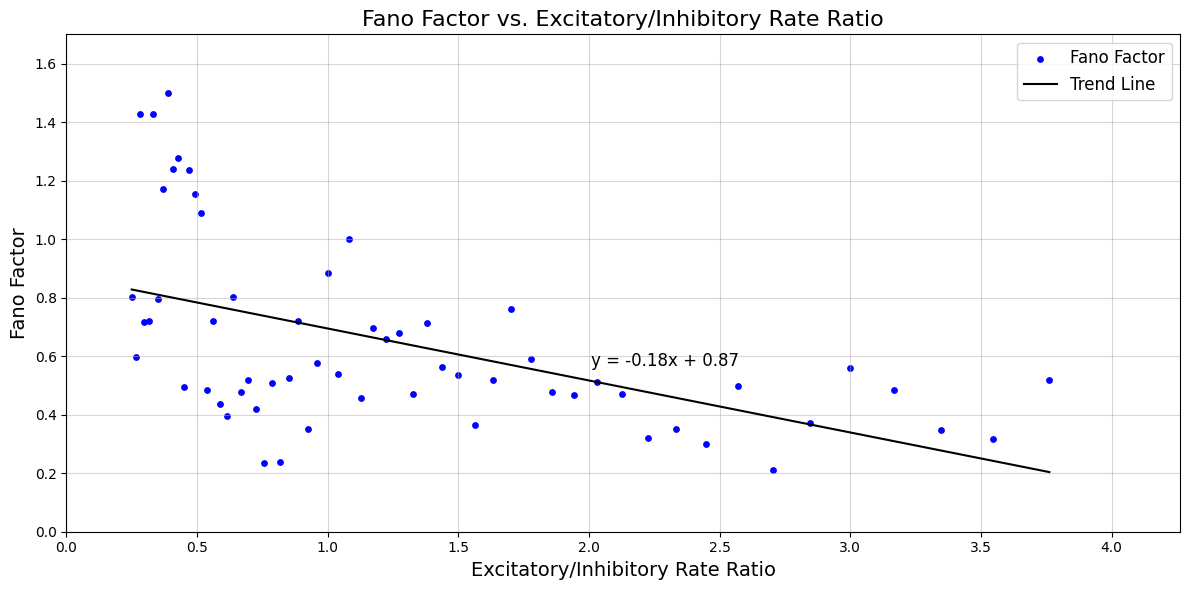

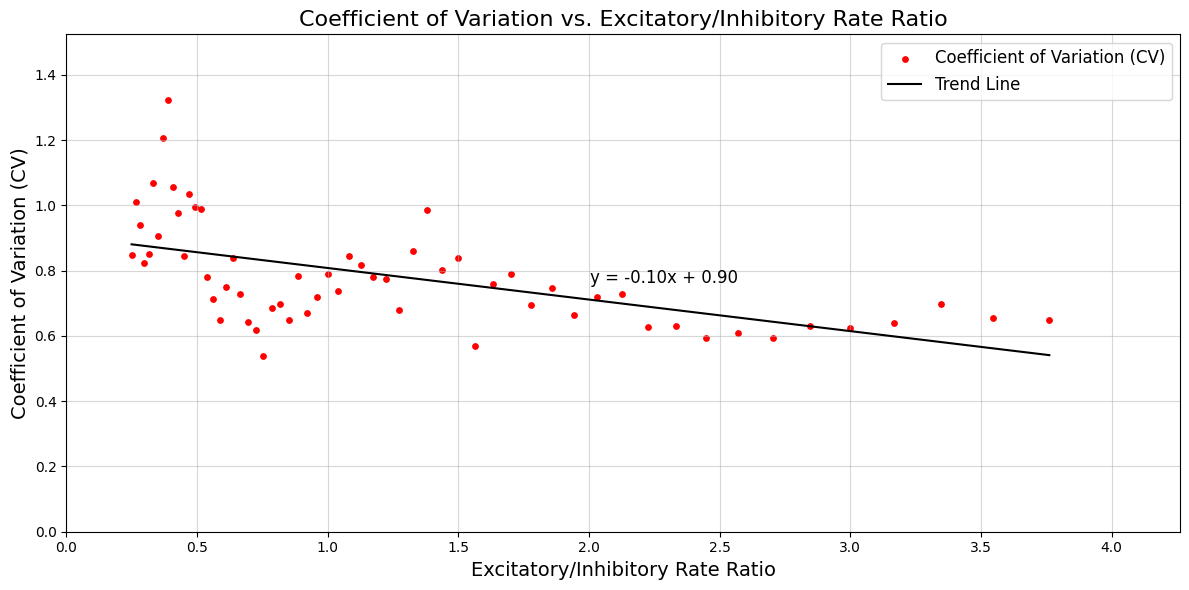

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# post synaptic firing rate goal
firing_rate_goal = 100
tolerance = 5
max_iterations = 20

#LIF PARAMETERS
tau_m = 10
E_L = -70
V_r = -70
V_t = -40
R_m = 10 
dt = 1 # time step of 1ms
T = 1000  # Total simulation time in ms

#SYNAPTIC INPUT PARAMETERS
#stronger input -> increase rate of exc, weight of exc, ratio of e/i
rate_exc = np.arange(100, 400, 5)
rate_inh = np.arange(400, 100, -5)
w_exc = 1
w_inh = 1
fano_records = []
cv_records = []
ratio_records =[] 



for simulation in range(len(rate_exc)):
    curr_exc = rate_exc[simulation]
    curr_inh = rate_inh[simulation]
    ratio_records.append(curr_exc/curr_inh)
    
    for iteration in range(max_iterations):
        time = np.arange(0, T, dt) # [0,1,2,.....999] 1ms time step in 1 second
        V = E_L * np.ones(len(time))
        spike_times = []

        exc_spikes = np.random.poisson(curr_exc * dt / 1000, len(time))
        inh_spikes = np.random.poisson(curr_inh * dt / 1000, len(time))

        for t in range(1, len(time)):
            I_syn = w_exc * exc_spikes[t]  - w_inh * inh_spikes[t]
            dV = (-(V[t - 1] - E_L) + R_m * I_syn) / tau_m
            V[t] = V[t - 1] + dt * dV

            if V[t] >= V_t:
                spike_times.append(time[t])
                V[t] = V_r #reset!

        spike_times = np.array(spike_times)
        firing_rate = len(spike_times)
        # break if output is within tolerance
        if abs(firing_rate - firing_rate_goal) <= tolerance:
            break
        rate_difference = firing_rate_goal - firing_rate
        adjustment_factor = 0.1  

        # adjustments
        if firing_rate < firing_rate_goal:
            w_exc += adjustment_factor * rate_difference
        else:
            w_exc += adjustment_factor * rate_difference
    ''' now that we have spike times, we can create ISI'''
    isis = np.diff(spike_times)
    bin_width = 50 
    num_bins = int(T / bin_width)
    spike_counts, _ = np.histogram(spike_times, bins=num_bins)
    fano_factor = np.var(spike_counts, ddof=1) / np.mean(spike_counts)
    cv = np.std(isis, ddof=1) / np.mean(isis)
    fano_records.append(fano_factor)
    cv_records.append(cv)

print(f"Ratio Records: {ratio_records}")
print(f"Fano Records: {fano_records}")
print(f"CV Records: {cv_records}")



#### ALL PLOT RELATED STUFF ####


#FANO 
slope_fano, intercept_fano, _, _, _ = linregress(ratio_records, fano_records)
trend_fano = slope_fano * np.array(ratio_records) + intercept_fano
plt.figure(figsize=(12, 6))
plt.scatter(ratio_records, fano_records, color='blue', s=15, label='Fano Factor')

plt.plot(ratio_records, trend_fano, color='black', linestyle='-', label='Trend Line')
x_pos = (max(ratio_records) + min(ratio_records)) / 2 
y_pos = slope_fano * x_pos + intercept_fano  
equation_fano = f"y = {slope_fano:.2f}x + {intercept_fano:.2f}"
plt.text(x_pos, y_pos + 0.05, equation_fano, fontsize=12, color='black') 


plt.xlabel("Excitatory/Inhibitory Rate Ratio", fontsize=14)
plt.ylabel("Fano Factor", fontsize=14)
plt.xlim(0, max(ratio_records) + 0.5)
plt.ylim(0, max(fano_records) + 0.2)
plt.title("Fano Factor vs. Excitatory/Inhibitory Rate Ratio", fontsize=16)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()




#CV
slope_cv, intercept_cv, _, _, _ = linregress(ratio_records, cv_records)
trend_cv = slope_cv * np.array(ratio_records) + intercept_cv
plt.figure(figsize=(12, 6))
plt.scatter(ratio_records, cv_records, color='red',s=15, label='Coefficient of Variation (CV)')

plt.plot(ratio_records, trend_cv, color='black', linestyle='-', label='Trend Line')
x_pos = (max(ratio_records) + min(ratio_records)) / 2 
y_pos = slope_cv * x_pos + intercept_cv  
equation_cv = f"y = {slope_cv:.2f}x + {intercept_cv:.2f}"
plt.text(x_pos, y_pos + 0.05, equation_cv, fontsize=12, color='black')


plt.xlabel("Excitatory/Inhibitory Rate Ratio", fontsize=14)
plt.ylabel("Coefficient of Variation (CV)", fontsize=14)
plt.title("Coefficient of Variation vs. Excitatory/Inhibitory Rate Ratio", fontsize=16)
plt.xlim(0, max(ratio_records) + 0.5)
plt.ylim(0, max(cv_records) + 0.2)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

